In [3]:
# 引入需要的代码库

import datetime as dt
import matplotlib.pyplot as plt # 图表生成库
from matplotlib import style
import pandas as pd # 数据分析库
import pandas_datareader.data as web # 用来下载下载数据

In [2]:
style.use('ggplot')

# 设定时间段的变量
start = dt.datetime(2016, 1, 1)
end = dt.datetime.now()

# 数据框 - Excel表那种文件
df = web.DataReader('TSLA', 'yahoo', start, end)

High         Low        Open       Close   Volume  \
Date                                                                  
2015-12-31  243.449997  238.369995  238.509995  240.009995  2715000   
2016-01-04  231.380005  219.000000  230.720001  223.410004  6827100   
2016-01-05  226.889999  220.000000  226.360001  223.429993  3186800   
2016-01-06  220.050003  215.979996  220.000000  219.039993  3779100   
2016-01-07  218.440002  213.669998  214.190002  215.649994  3554300   

             Adj Close  
Date                    
2015-12-31  240.009995  
2016-01-04  223.410004  
2016-01-05  223.429993  
2016-01-06  219.039993  
2016-01-07  215.649994  


In [7]:
# 保存数据成Excel文件
df.to_csv('tsla.csv')

In [ ]:
# 读取数据
df = pd.read_csv('tsla.csv', parse_dates=True, index_col=0)

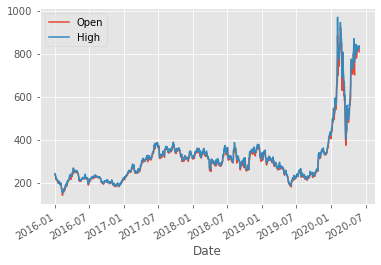

In [14]:
df[['Open', 'High']].plot()

In [18]:
df['100ma'] = df['Adj Close'].rolling(window=100, min_periods=0).mean()

print(df.tail())

High         Low        Open       Close    Volume  \
Date                                                                   
2020-05-22  831.780029  812.000000  822.169983  816.880005   9987500   
2020-05-26  834.599976  815.710022  834.500000  818.869995   8089700   
2020-05-27  827.710022  785.000000  820.859985  820.229980  11549500   
2020-05-28  824.750000  801.690002  813.510010  805.809998   7255600   
2020-05-29  835.000000  804.210022  808.750000  835.000000  11764500   

             Adj Close       100ma  
Date                                
2020-05-22  816.880005  656.160601  
2020-05-26  818.869995  660.166001  
2020-05-27  820.229980  664.065700  
2020-05-28  805.809998  667.693700  
2020-05-29  835.000000  671.528300  


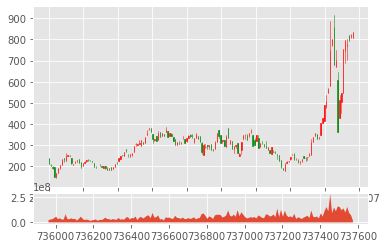

In [31]:
# mpl_finance库被废弃了，新库mplfinance用法不同。用以下指令直接从源码库进行安装:
# pip install git+https://github.com/matplotlib/mpl_finance.git

from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_volume = df['Volume'].resample('10D').sum()

df_ohlc.reset_index(inplace=True)

df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)

axis1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
axis2 = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1)
axis1.xaxis_date()

candlestick_ohlc(axis1, df_ohlc.values, width=2, colorup='r', colordown='g')
axis2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0)

plt.show()

In [35]:
# 爬虫爬取维基百科

import bs4 as bs
import requests

def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text)
    table = soup.find('table', {'id': 'constituents'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text.replace('\n', '')
        tickers.append(ticker)

    not_pickle = pd.DataFrame(tickers, columns=['Symbol'])
    not_pickle.to_csv('sp500tickers.csv')
    return not_pickle

save_sp500_tickers()

,Symbol
0,MMM\n
1,ABT\n
2,ABBV\n
3,ABMD\n
4,ACN\n
...,...
500,YUM\n
501,ZBRA\n
502,ZBH\n
503,ZION\n


In [5]:
import os

def get_data_from_yahoo(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        tickers = pd.read_csv('icaretickers.csv', parse_dates=True, index_col=0)['Symbol']

    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')

    start = dt.datetime(2010, 1, 1)
    end = dt.datetime(2020, 5, 1)

    for ticker in tickers[:20]: # 只使用头20家公司
        print(ticker)
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df = web.DataReader(ticker, 'yahoo', start, end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else:
            print('已经有 {}'.format(ticker))

get_data_from_yahoo()

TSLA
LK
AAPL
AMZN
BIDU
KO
QCOM
FB
TCOM
AMD
DIS
DOYU
INTC
DELL
JD
BABA
EBAY
ATVI
GOOGL
MSFT


In [6]:
def compile_data():
    tickers = pd.read_csv('icaretickers.csv', parse_dates=True, index_col=0)['Symbol'][:20]

    main_df = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)

        df.rename(columns = { 'Adj Close': ticker }, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)

        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')

        if count % 10 == 0:
            print(count)
    print(main_df.head())
    main_df.to_csv('icare_joined_closes.csv')

compile_data()

0
10
            TSLA  LK       AAPL        AMZN       BIDU         KO       QCOM  \
Date                                                                           
2009-12-31   NaN NaN  26.061205  134.520004  41.123001  19.278732  34.760757   
2010-01-04   NaN NaN  26.466835  133.899994  41.002998  19.292267  35.271713   
2010-01-05   NaN NaN  26.512596  134.690002  40.590000  19.058893  36.120834   
2010-01-06   NaN NaN  26.090879  132.250000  41.250000  19.052124  35.767658   
2010-01-07   NaN NaN  26.042646  130.000000  40.463001  19.004770  36.804634   

            FB       TCOM   AMD        DIS  DOYU       INTC  DELL  JD  BABA  \
Date                                                                          
2009-12-31 NaN  17.965000  9.68  28.090706   NaN  14.817140   NaN NaN   NaN   
2010-01-04 NaN  18.125000  9.70  27.933924   NaN  15.165774   NaN NaN   NaN   
2010-01-05 NaN  19.137501  9.71  27.864237   NaN  15.158516   NaN NaN   NaN   
2010-01-06 NaN  18.732500  9.57  27.716

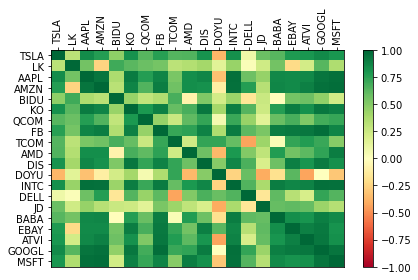

In [7]:
import numpy as np

def visualize_data():
    df = pd.read_csv('icare_joined_closes.csv')
    df_corr = df.corr()

    data = df_corr.values
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1)

    heatmap = axis.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    axis.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    axis.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    axis.invert_yaxis()
    axis.xaxis.tick_top()

    column_labels = df_corr.columns
    row_labels = df_corr.index

    axis.set_xticklabels(column_labels)
    axis.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()

visualize_data()